In [90]:
#!/usr/bin/env python3
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from pathlib import Path
from typing import cast
import h5py
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import argparse

In [91]:
# Constants
batch_size = 128
num_workers = 10
n_geno = 100000
n_alleles = 2
n_loci = n_geno * n_alleles

In [92]:
#1 epoch loss 0.417
#encoder = "optuna/best_encoder_gg_20250226_234932.pt"
#decoder = "optuna/best_decoder_gg_20250226_234932.pt"

#16 epochs loss 0.259
#encoder = "optuna/test_sim_WF_10kbt_10000n_5000000bp_gg_encoder.pt"
#decoder = "optuna/test_sim_WF_10kbt_10000n_5000000bp_gg_decoder.pt"

#24 epochs saved (out of 50) loss 0.2536
encoder = "gpatlas/optuna/best_encoder_gg_20250310_234842.pt"
decoder = "gpatlas/optuna/best_decoder_gg_20250310_234842.pt"

###optuna pipeline results
#encoder = "optuna/test_sim_WF_null_10000n_5000000bp_gg_encoder.pt"
#decoder = "optuna/test_sim_WF_null_10000n_5000000bp_gg_decoder.pt"

test_data = 'gpatlas_input/test_sim_WF_null_10000n_5000000bp_test.hdf5'
n_loci_viz = 10000
threshold = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [93]:

# Dataset classes
class BaseDataset(Dataset):
    def __init__(self, hdf5_path: Path) -> None:
        self.h5 = h5py.File(hdf5_path, "r")
        self._strain_group = cast(h5py.Group, self.h5["strains"])
        self.strains: list[str] = list(self._strain_group.keys())

    def __len__(self) -> int:
        return len(self._strain_group)

class GenoDataset(BaseDataset):
    def __getitem__(self, idx: int) -> torch.Tensor:
        strain = self.strains[idx]
        strain_data = cast(Dataset, self._strain_group[strain])
        gens = torch.tensor(strain_data["genotype"][:], dtype=torch.float32).flatten()
        return gens

# Model classes
class GQ_net(nn.Module):
    def __init__(self, n_loci=None, N=None):
        super().__init__()
        if n_loci is None:
            n_loci = n_geno * n_alleles

        batchnorm_momentum = 0.8
        g_latent_dim = N
        self.encoder = nn.Sequential(
            nn.Linear(in_features=n_loci, out_features=N),
            nn.BatchNorm1d(N, momentum=0.8),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=N, out_features=g_latent_dim),
            nn.BatchNorm1d(g_latent_dim, momentum=0.8),
            nn.LeakyReLU(0.01),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

class GP_net(nn.Module):
    def __init__(self, n_loci=None, N=None):
        super().__init__()
        if n_loci is None:
            n_loci = n_geno * n_alleles

        batchnorm_momentum = 0.8
        g_latent_dim = N
        self.encoder = nn.Sequential(
            nn.Linear(in_features=g_latent_dim, out_features=N),
            nn.BatchNorm1d(N, momentum=batchnorm_momentum),
            nn.LeakyReLU(0.01),
            nn.Linear(in_features=N, out_features=n_loci),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


In [94]:

def load_models(encoder_path, decoder_path=None, device='cuda'):
    """Load the encoder and decoder models from checkpoints"""
    # Load encoder
    encoder_checkpoint = torch.load(encoder_path, map_location=device)
    latent_space_g = encoder_checkpoint['hyperparameters']['latent_space_g']

    GQ = GQ_net(n_loci=n_loci, N=latent_space_g).to(device)
    GQ.load_state_dict(encoder_checkpoint['model_state_dict'])
    GQ.eval()

    # Load decoder if provided separately
    if decoder_path:
        decoder_checkpoint = torch.load(decoder_path, map_location=device)
        GP = GP_net(n_loci=n_loci, N=latent_space_g).to(device)
        GP.load_state_dict(decoder_checkpoint['model_state_dict'])
    else:
        # If no separate decoder, assume encoder checkpoint has all model info
        GP = GP_net(n_loci=n_loci, N=latent_space_g).to(device)
        if 'decoder_state_dict' in encoder_checkpoint:
            GP.load_state_dict(encoder_checkpoint['decoder_state_dict'])

    GP.eval()

    return GQ, GP, latent_space_g


In [95]:

def evaluate_autoencoder(GQ, GP, test_loader, device, threshold=0.5):
    """
    Evaluate the autoencoder performance at the allele level

    Returns:
    - correct_allele: count of correctly reconstructed alleles
    - wrong_allele: count of incorrectly reconstructed alleles
    - invalid_state: count of reconstructed invalid states
    - minor_allele_freq: minor allele frequency for each locus
    """
    # Initialize counters per locus position
    n_positions = n_loci_viz
    correct_allele = np.zeros(n_positions)
    correct_allele_0 = np.zeros(n_positions)
    correct_allele_1 = np.zeros(n_positions)
    wrong_allele = np.zeros(n_positions)
    invalid_state = np.zeros(n_positions)

    # Initialize counters for allele frequencies
    allele1_count = np.zeros(n_positions)  # Count of (1,0) genotypes

    total_samples = 0

    # Process batches
    with torch.no_grad():
        for gens in test_loader:
            batch_size = gens.shape[0]
            total_samples += batch_size

            gens = gens.to(device)

            # Run through autoencoder
            latent = GQ(gens)
            reconstructed = GP(latent)

            # Convert to binary representation (threshold outputs)
            reconstructed_binary = (reconstructed > threshold).float()

            # Analyze per locus
            for pos in range(n_positions):
                # Get allele pairs for this locus
                allele1_idx = pos * n_alleles
                allele2_idx = pos * n_alleles + 1

                for sample_idx in range(batch_size):
                    true_allele1 = gens[sample_idx, allele1_idx].item()
                    true_allele2 = gens[sample_idx, allele2_idx].item()

                    # Count allele1 (1,0) genotypes for MAF calculation
                    if true_allele1 == 1 and true_allele2 == 0:
                        allele1_count[pos] += 1

                    recon_allele1 = reconstructed_binary[sample_idx, allele1_idx].item()
                    recon_allele2 = reconstructed_binary[sample_idx, allele2_idx].item()

                    # Case 1: Correct allele reconstruction
                    if (true_allele1 == recon_allele1 and true_allele2 == recon_allele2):
                        correct_allele[pos] += 1
                        #track number of correctly reconstructed 0 alleles
                        if (true_allele1 == recon_allele1 and true_allele2 == recon_allele2 and true_allele1 == 1):
                            correct_allele_0[pos] += 1
                        #track number of correctly reconstructed 0 alleles
                        if (true_allele1 == recon_allele1 and true_allele2 == recon_allele2 and true_allele2 == 1):
                            correct_allele_1[pos] += 1
                    # Case 3: Invalid allelic state
                    elif (recon_allele1 == 1 and recon_allele2 == 1) or (recon_allele1 == 0 and recon_allele2 == 0):
                        invalid_state[pos] += 1
                    # Case 2: Wrong allele
                    else:
                        wrong_allele[pos] += 1

    # Calculate MAF
    daf = (1-allele1_count/ total_samples)

    # Convert to percentages
    correct_allele = (correct_allele / total_samples) * 100
    wrong_allele = (wrong_allele / total_samples) * 100
    invalid_state = (invalid_state / total_samples) * 100

    return correct_allele, correct_allele_0, correct_allele_1, wrong_allele, invalid_state, daf, total_samples


In [96]:

# Load data
test_data = GenoDataset(test_data)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False
)

# Load models
GQ, GP, latent_space_g = load_models(encoder, decoder, device)

print(f"Models loaded successfully. Latent space size: {latent_space_g}")
print(f"Evaluating on {len(test_data)} test samples...")


/tmp/ipykernel_2590622/810046011.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_checkpoint = torch.load(encoder_path, map_location=device)
/tmp/ipykernel_259062

Models loaded successfully. Latent space size: 3500
Evaluating on 1500 test samples...


In [97]:
# Evaluate
correct_allele, correct_allele_0, correct_allele_1, wrong_allele, invalid_state, daf, total_samples = evaluate_autoencoder(
    GQ, GP, test_loader, device, threshold
)


In [98]:
dataset = pd.DataFrame({'correct_allele': correct_allele, 'correct_allele_0': correct_allele_0,
                        'correct_allele_1': correct_allele_1,'wrong_allele': wrong_allele,
                        'invalid_state': invalid_state,'daf': daf, 'total_samples' : total_samples})

dataset['maf'] = np.minimum(dataset['daf'], 1 - dataset['daf'])
dataset

,correct_allele,correct_allele_0,correct_allele_1,wrong_allele,invalid_state,daf,total_samples,maf
0,97.000000,1455.0,0.0,3.000000,0.000000,0.030000,1500,0.030000
1,76.066667,6.0,1135.0,22.933333,1.000000,0.770000,1500,0.230000
2,98.800000,1482.0,0.0,1.200000,0.000000,0.012000,1500,0.012000
3,99.400000,1491.0,0.0,0.600000,0.000000,0.006000,1500,0.006000
4,99.933333,1499.0,0.0,0.066667,0.000000,0.000667,1500,0.000667
...,...,...,...,...,...,...,...,...
9995,76.933333,1152.0,2.0,23.066667,0.000000,0.232000,1500,0.232000
9996,98.733333,1481.0,0.0,1.266667,0.000000,0.012667,1500,0.012667
9997,75.200000,1124.0,4.0,23.733333,1.066667,0.241333,1500,0.241333
9998,83.133333,1247.0,0.0,16.733333,0.133333,0.167333,1500,0.167333


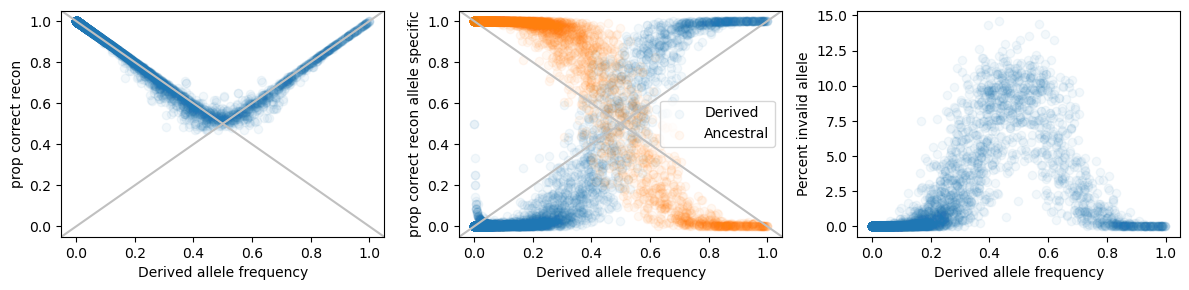

In [99]:
# Create a figure with 2 side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(12, 3))  # 1 row, 2 columns

# first plot
axes[0].scatter(dataset['daf'], dataset['correct_allele']/100, alpha=0.05)
axes[0].set_xlabel("Derived allele frequency")
axes[0].set_ylabel("prop correct recon")
axes[0].axline((1, 0), slope=-1, color = 'silver')
axes[0].axline((1, 1), slope=1, color = 'silver')


# second plot
axes[1].scatter(dataset['daf'], (dataset['correct_allele_1'])/(1500*dataset['daf']), label='Derived', alpha=0.05)
axes[1].scatter(dataset['daf'], (dataset['correct_allele_0'])/(1500*(1-dataset['daf'])), label='Ancestral', alpha=0.05)
axes[1].set_xlabel("Derived allele frequency")
axes[1].set_ylabel("prop correct recon allele specific")
axes[1].axline((1, 0), slope=-1, color = 'silver')
axes[1].axline((1, 1), slope=1, color = 'silver')
axes[1].legend()

# third plot
axes[2].scatter(dataset['daf'], dataset['invalid_state'], alpha=0.05)
axes[2].set_xlabel("Derived allele frequency")
axes[2].set_ylabel("Percent invalid allele")

# Adjust layout and spacing
plt.tight_layout()
plt.show()

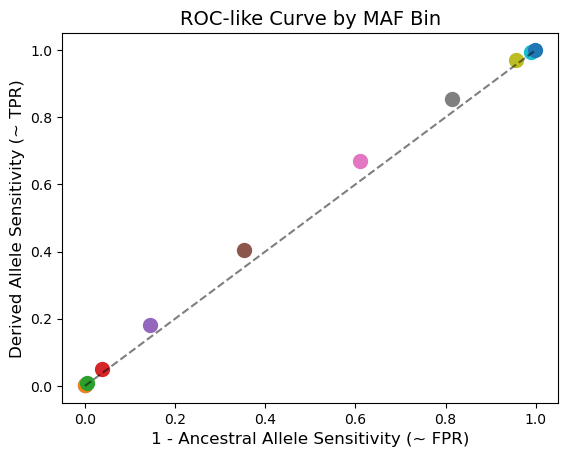

Statistics by MAF bin:
     maf_bin  count  derived_sensitivity  ancestral_sensitivity
0     0-0.05   6967             0.001915               0.999990
1   0.05-0.1    697             0.002631               0.999688
2    0.1-0.2    686             0.008949               0.995335
3    0.2-0.3    415             0.051257               0.962248
4    0.3-0.4    298             0.180287               0.856478
5    0.4-0.5    235             0.404333               0.646585
6    0.5-0.6    190             0.670592               0.389915
7    0.6-0.7    150             0.854992               0.184981
8    0.7-0.8    127             0.969120               0.043697
9    0.8-0.9    135             0.994639               0.009864
10     0.9-1    100             0.999820               0.002767


In [100]:
# %%
# Create ROC curves by MAF bin
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Create MAF bins
maf_bins = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
bin_labels = ['0-0.05', '0.05-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5','0.5-0.6','0.6-0.7','0.7-0.8','0.8-0.9', '0.9-1']

# Add bin column to dataset
dataset['maf_bin'] = pd.cut(dataset['daf'], bins=maf_bins, labels=bin_labels, right=False)

# Process the data to generate ROC-like metrics
bin_data = []

# For each MAF bin, compute metrics
for bin_name in bin_labels:
    bin_subset = dataset[dataset['maf_bin'] == bin_name]

    if len(bin_subset) < 10:  # Skip bins with too few variants
        continue

    # Calculate derived allele metrics
    avg_daf = bin_subset['daf'].mean()
    derived_sensitivity = (bin_subset['correct_allele_1'] / (bin_subset['daf'] * total_samples)).mean()

    # Calculate ancestral allele metrics
    ancestral_sensitivity = (bin_subset['correct_allele_0'] / ((1-bin_subset['daf']) * total_samples)).mean()

    bin_data.append({
        'maf_bin': bin_name,
        'count': len(bin_subset),
        'derived_sensitivity': derived_sensitivity,
        'ancestral_sensitivity': ancestral_sensitivity,
        'avg_daf': avg_daf
    })

bin_df = pd.DataFrame(bin_data)

# Plot ROC-like curve
#plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')

# Plot each bin as a point
for i, row in bin_df.iterrows():
    plt.scatter(1 - row['ancestral_sensitivity'], row['derived_sensitivity'],
                s=100)

plt.xlabel('1 - Ancestral Allele Sensitivity (~ FPR)', fontsize=12)
plt.ylabel('Derived Allele Sensitivity (~ TPR)', fontsize=12)
plt.title('ROC-like Curve by MAF Bin', fontsize=14)
#plt.grid(alpha=0.3)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

#plt.tight_layout()
plt.show()

# Print summary statistics
print("Statistics by MAF bin:")
print(bin_df[['maf_bin', 'count', 'derived_sensitivity', 'ancestral_sensitivity']])